<a href="https://colab.research.google.com/github/aghosh92/DKLActiveLearnMol/blob/main/Notebooks/notebookII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, we explore the latent space generated by a deep kernel learning (DKL) model for molecules. This approach gives a better structured latent spaces compared to those generated by traditional variational autoencoders (VAEs). DKL builds latent space based on the features and target.


- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh (SMIILES to SELFIES part), research.aghosh@gmail.com
- The GPax is by Maxim Ziatdinov, https://github.com/ziatdinovmax/gpax
- The DKL is adapted from the notebooks from Mani Valleti, svalleti@vols.utk.edu
- Workflow built by Sergei V. Kalinin
- DKL for subsets of QM9 dataset adapted by Ayana Ghosh

In [1]:
# @title Install packages
!pip install wget
!pip install rdkit-pypi
!pip install selfies --upgrade
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax
!pip install -q atomai  # we will use the AtomAI VAE

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [16]:
# @title Import libraries
import wget
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import warnings

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw

import torch
import torch.nn as nn
tt = torch.tensor
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize
from scipy.spatial import distance

import selfies as sf
import gpax
import atomai as aoi

import jax.numpy as jnp
gpax.utils.enable_x64()

In [22]:
# @title Utility functions
def find_nearest_neighbors(reference_idx, embedding, num_neighbors=9):
    """Find the indices of the nearest neighbors to a reference point."""
    reference_point = embedding[reference_idx]
    distances = distance.cdist([reference_point], embedding, 'euclidean').flatten()
    nearest_indices = np.argsort(distances)[1:num_neighbors+1]  # Exclude the reference point itself
    warnings.filterwarnings("ignore", category=UserWarning)  # Ignore userwarnings
    return nearest_indices

def find_indices(original, search):
    indices = []
    for row in search:
        # Find the index of the row in the original array
        index = np.where((original == row).all(axis=1))[0]
        if index.size > 0:
            indices.append(index[0])
        else:
            indices.append(-1)  # -1 indicates not found
    return np.array(indices)

def are_points_separated(point, other_points, min_distance):
    """Check if 'point' is at least 'min_distance' away from all points in 'other_points'."""
    return np.all(np.linalg.norm(other_points - point, axis=1) >= min_distance)

Read in dataset (One of the subsets from QM9 containing 5,000 randomly selected molecules)

In [4]:
git_link = "https://github.com/aghosh92/DKLActiveLearnMol/blob/main/datasets/dataset0_5k.csv?raw=true"
df = pd.read_csv(git_link, index_col=0)
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,...,stereocent,dipole_moment,enthalpy,internal_energy,internal_energy_zero,free_energy,homo,lumo,gap,zero_point_vib_energy
80704,OCC(C#C)C#CC#C,-0.13530,20.23,118.041865,1,1,"(44,)",0.104838,-0.394070,1,...,1,1.0110,-383.379422,-383.380366,-383.390139,-383.425247,-0.2487,-0.0227,0.2260,0.109023
65243,OC1C2NC1(C#C)C2O,-1.93440,52.49,125.047678,3,3,"(48,)",0.135711,-0.388302,0,...,2,2.9389,-437.764349,-437.765293,-437.773455,-437.805879,-0.2457,0.0183,0.2640,0.123328
127044,C1C2C3CC(CCO3)N12,0.23180,12.24,125.084064,0,2,"(50,)",0.075724,-0.376416,0,...,4,1.2046,-403.111686,-403.112630,-403.119162,-403.149575,-0.2233,0.0819,0.3052,0.175386
78132,CC1=CC2CC(O2)C1O,0.46470,29.46,126.068080,1,2,"(50,)",0.101096,-0.386045,0,...,3,2.0914,-423.006427,-423.007371,-423.015176,-423.047111,-0.2388,0.0018,0.2405,0.160473
90425,CC1CC1(O)CCC=O,0.73640,37.30,128.083730,1,2,"(52,)",0.119600,-0.389588,3,...,2,2.1074,-424.213274,-424.214219,-424.224729,-424.261135,-0.2481,-0.0208,0.2273,0.178994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117107,OC1C2C3NC3(C#N)C12,-1.15892,65.96,122.048013,2,3,"(46,)",0.128183,-0.392345,0,...,5,6.3772,-416.738039,-416.738983,-416.746403,-416.778259,-0.2729,0.0142,0.2871,0.113488
8240,NC(=O)C(=O)NCC=O,-2.21320,89.26,130.037842,2,3,"(50,)",0.308947,-0.361393,2,...,0,2.7234,-491.145917,-491.146862,-491.156301,-491.192146,-0.2543,-0.0462,0.2081,0.111181
82724,CC1C(C)N1CC1CO1,0.47780,15.54,127.099714,0,2,"(52,)",0.093621,-0.371734,2,...,3,2.2996,-404.281755,-404.282699,-404.292728,-404.328359,-0.2208,0.0761,0.2969,0.192277
33180,NC(=O)C1CC1CCO,-0.50980,63.32,129.078979,2,2,"(52,)",0.220321,-0.396365,3,...,2,3.7023,-440.294320,-440.295265,-440.305434,-440.341331,-0.2486,0.0246,0.2732,0.170268


Convert smiles to one-hot vectors

In [5]:
selfies_dataset = []
error_smiles = []

# Assuming 'smiles' is the column in df containing SMILES strings
# Replace 'smiles' with the actual column name if it's different
for i, row in df.iterrows():
    try:
        local_sf = sf.encoder(row['smiles'])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(row['smiles'])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

length_list = []
for s in selfies_dataset:
  length = sf.len_selfies(s)
  length_list.append(length)
length_list.sort()
pad_to_len = length_list[-1]

symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

molecules = np.array(one_hot_vectors)
s1, s2, s3 = molecules.shape
X = np.asarray(molecules).reshape([-1,s2*s3])
print(X.shape)

(5000, 567)


In [14]:
#Different targets
targets1 = df['ringct'].values
targets2 = df['mole_logp'].values
targets3 = df['mol_wt'].values
targets4 = df['dipole_moment'].values

For illustration purpose, we show the training on 1,000 molecules since training on a higher number of molecules may take longer & more computing resources.

In [15]:
X1 = np.copy(X)
X1 = X1[:1000]
targets1 = targets1[:1000]

#Train the DKL model
rng_key_1, rng_key_predict_1 = gpax.utils.get_keys()
dkl_1 = gpax.viDKL(s2*s3, 2, 'RBF')
dkl_1.fit(rng_key_1, X1, targets1)

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s, init loss: 41045.4279, avg. loss [951-1000]: 36806.3720]



Inferred GP kernel parameters
k_length         [1.4378 1.226 ]
k_scale          5.5997
noise            0.0154


Visualize the DKL latent space with the Labels correpsonding to the target and several other parameters.

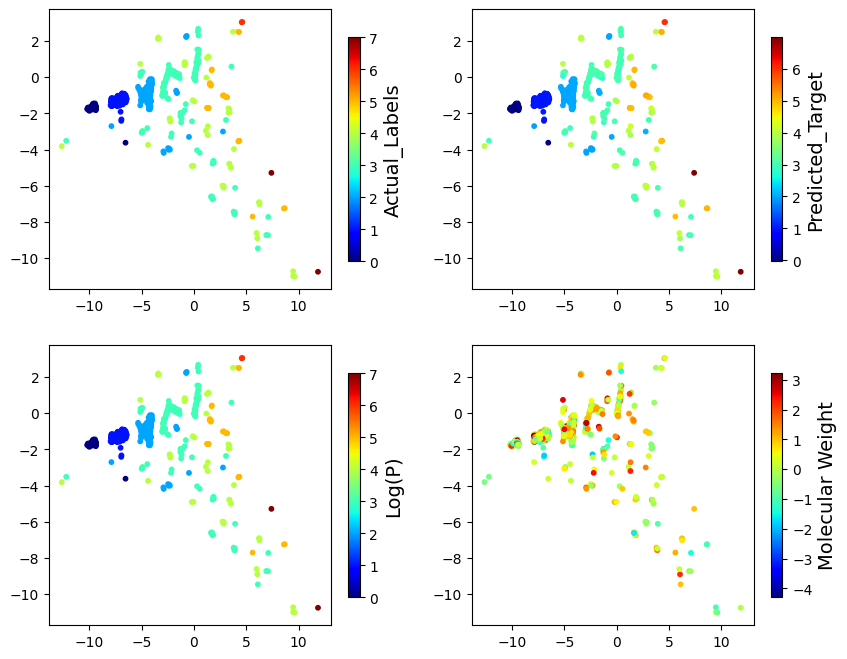

In [18]:
batch_size_reconstruct = 250

embeded_1 = dkl_1.embed(X1)
pred_mean1, pred_var1 = dkl_1.predict_in_batches(rng_key_predict_1, X1, batch_size=batch_size_reconstruct)
pred_std1 = jnp.sqrt(pred_var1)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

im = ax[0,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = targets1, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,0], shrink=.8)
cbar.set_label("Actual_Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[0,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = pred_mean1, cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[0,1], shrink=.8)
cbar.set_label("Predicted_Target", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = targets1,
                     cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,0], shrink=.8)
cbar.set_label("Log(P)", fontsize=14)
cbar.ax.tick_params(labelsize=10)

im = ax[1,1].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = targets2[:1000], cmap = 'jet')
cbar = fig.colorbar(im, ax=ax[1,1], shrink=.8)
cbar.set_label("Molecular Weight", fontsize=14)
cbar.ax.tick_params(labelsize=10)

Text(0.5, 1.0, 'Dipole Moment')

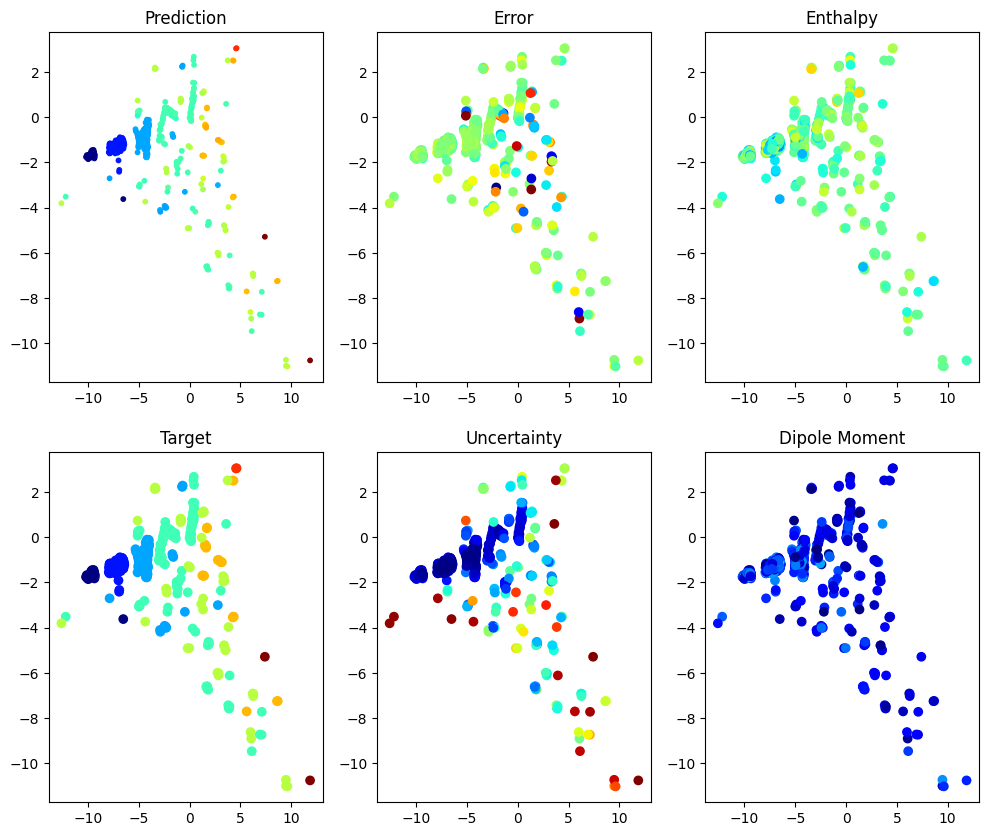

In [19]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12,10))
ax[0,0].scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c = pred_mean1, cmap='jet')
ax[0,0].set_title('Prediction')
ax[0,1].scatter(embeded_1[:, 1], embeded_1[:, 0], c = targets1 - pred_mean1, cmap='jet')
ax[0,1].set_title('Error')
ax[0,2].scatter(embeded_1[:, 1], embeded_1[:, 0], c = df['enthalpy'][:1000], cmap='jet')
ax[0,2].set_title('Enthalpy')
ax[1,0].scatter(embeded_1[:, 1], embeded_1[:, 0], c = targets1, cmap='jet')
ax[1,0].set_title('Target')
ax[1,1].scatter(embeded_1[:, 1], embeded_1[:, 0], c = pred_var1, cmap='jet')
ax[1,1].set_title('Uncertainty')
ax[1,2].scatter(embeded_1[:, 1], embeded_1[:, 0], c = df['dipole_moment'][:1000], cmap='jet')
ax[1,2].set_title('Dipole Moment')

Extract molecules from the latent space with largest variation in prediction.

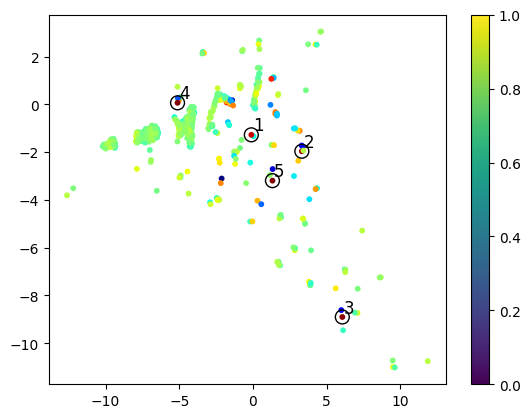

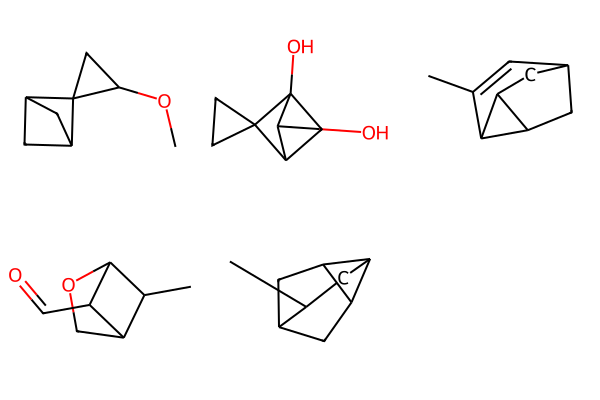

In [23]:
# Find indices of the 5 maximal points in pred_var5
max_indices = np.argsort(targets1 - pred_mean1)[-5:]

# Plot the original scatter plot
plt.scatter(embeded_1[:, 1], embeded_1[:, 0], s=10,
            c=targets1 - pred_mean1, cmap='jet')

# Plot circles and offset numbers around the 5 maximal points
for i, idx in enumerate(max_indices):
    plt.scatter(embeded_1[idx, 1], embeded_1[idx, 0],
                s=100, facecolors='none', edgecolors='black')
    # Offset the text slightly from the circle
    plt.text(embeded_1[idx, 1] + 0.12, embeded_1[idx, 0] + 0.18,
             str(i+1), color='black', fontsize=12)

plt.colorbar()
plt.show()

# Retrieve rows from df corresponding to max_indices
maximal_rows = df.iloc[max_indices]

# Extract SMILES strings in the order of max_indices
smiles_list = maximal_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects in the same order
molecules_2 = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Annotate molecules with numbers corresponding to their order
for i, mol in enumerate(molecules_2):
    if mol is not None:
        mol.SetProp("_Name", str(i+1))


# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules_2, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
img


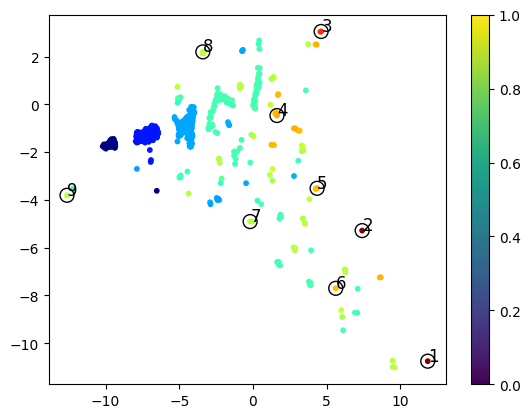

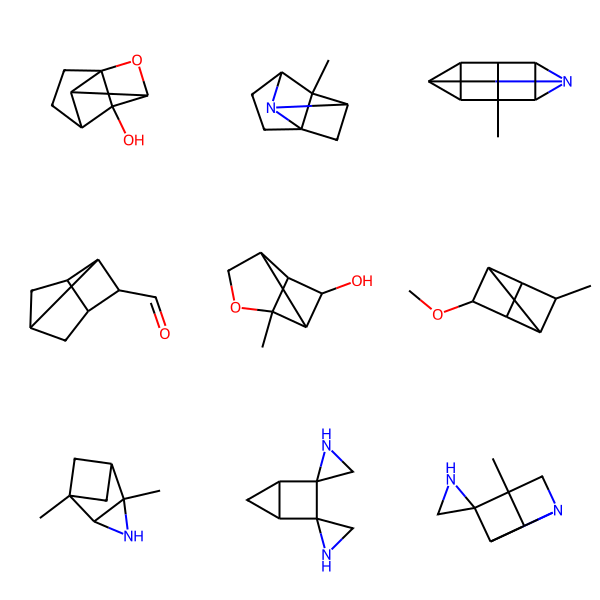

In [24]:
# Sort indices by descending pred_var5 value
sorted_indices = np.argsort(pred_mean1)[::-1]

max_indices = []
min_distance = 3  # Set a minimum distance, adjust as needed

for idx in sorted_indices:
    if len(max_indices) >= 9:
        break
    point = embeded_1[idx]
    # Convert max_indices to a numpy array for proper indexing
    if not max_indices or are_points_separated(point, embeded_1[np.array(max_indices)], min_distance):
        max_indices.append(idx)

# Plot the original scatter plot
plt.scatter(embeded_1[:, 1], embeded_1[:, 0], s=10, c=pred_mean1, cmap='jet')

# Plot circles and numbers around the 5 maximal points
for i, idx in enumerate(max_indices):
    plt.scatter(embeded_1[idx, 1], embeded_1[idx, 0], s=100, facecolors='none', edgecolors='black')
    plt.text(embeded_1[idx, 1] + 0.01, embeded_1[idx, 0] + 0.01, str(i+1), color='black', fontsize=12)

plt.colorbar()
plt.show()

# Retrieve rows from df corresponding to max_indices
maximal_rows = df.iloc[max_indices]

# Extract SMILES strings in the order of max_indices
smiles_list = maximal_rows['smiles'].tolist()

# Convert SMILES to RDKit molecule objects in the same order
molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]

# Annotate molecules with numbers corresponding to their order
for i, mol in enumerate(molecules):
    if mol is not None:
        mol.SetProp("_Name", str(i+1))

# Create a grid image of the molecules
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
img

Find nearest neighbor molecules

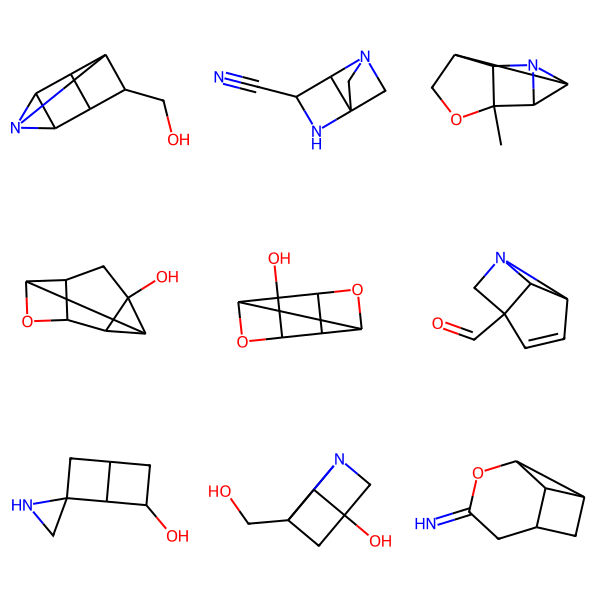

In [26]:
# Selecting a maximum and finding nearest neighbors
selected_max_idx = max_indices[0]  # Selecting the first maximum for demonstration
neighbor_indices = find_nearest_neighbors(selected_max_idx, embeded_1)
neighbor_rows = df.iloc[neighbor_indices]
neighbor_smiles = neighbor_rows['smiles'].tolist()
neighbor_molecules = [Chem.MolFromSmiles(smile) for smile in neighbor_smiles]
neighbor_img = Draw.MolsToGridImage(neighbor_molecules, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
neighbor_img